In [45]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
x = torch.linspace(0,899,900)

In [47]:
# create a sin function from our 900 input data
y = torch.sin(x*2*3.1416/40)

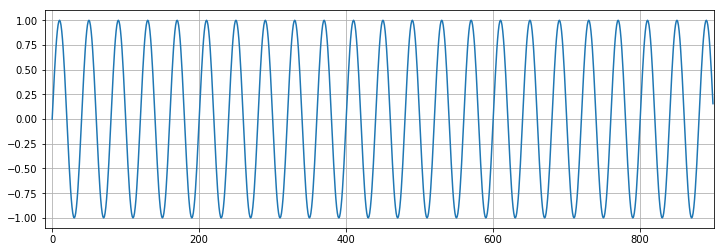

In [48]:
# plotting 'y'
plt.figure(figsize=(12,4))
plt.xlim(-10,901)
plt.grid(True)
plt.plot(y.numpy())

In [49]:
# save the last 40 points in my sequence for comparison to the RNN
test_size = 40

# split theata into train and est sets
train_set = y[:-test_size]
test_set = y[-test_size:]

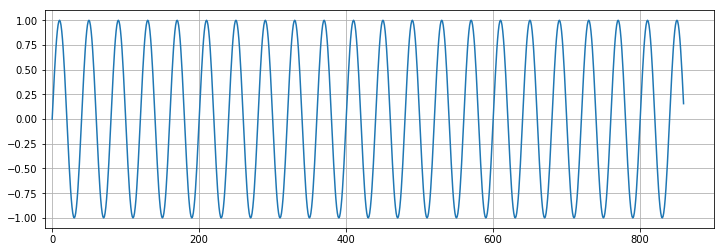

In [50]:
# plotting the train set 
plt.figure(figsize=(12,4))
plt.xlim(-10,901)
plt.grid(True)
plt.plot(train_set.numpy())

In [51]:
# split the training data into batches
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        win = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((win,label))
    
    return out

In [52]:
window_size = 40

train_data = input_data(train_set, window_size)

In [53]:
len(train_data)

820

900 
900-40=860 # first cut to train_set
860-40=820 # second cut because of ws

In [54]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [55]:
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

In [56]:
## we can see the label from the first batch is now the last training example in the second bach

In [57]:
# creaing LSTM nn
class LSTM(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=50,out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        prediction = self.linear(lstm_out.view(len(seq),-1))
        
        return prediction[-1]

In [58]:
# instantiate nw LSTM model
torch.manual_seed(42)
model = LSTM()

# etting a criterion and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [59]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [60]:
sum = 0
for param in model.parameters():
    sum += param.numel()
print(sum)

10651


#### train the model

Epoch 0 Loss: 0.09112300723791122
Performance on test range: 0.622702419757843


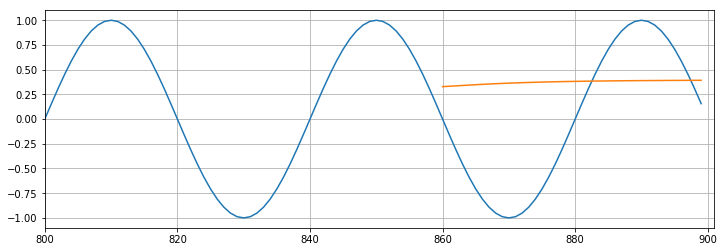

Epoch 1 Loss: 0.06231575831770897
Performance on test range: 0.5728602409362793


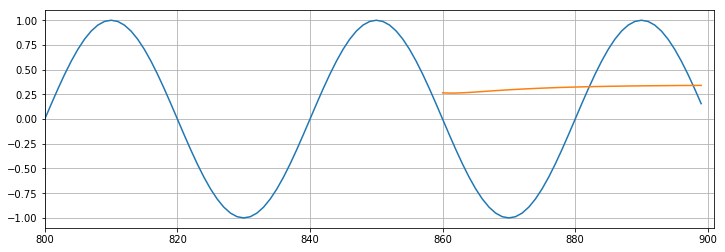

Epoch 2 Loss: 0.03536103665828705
Performance on test range: 0.506303071975708


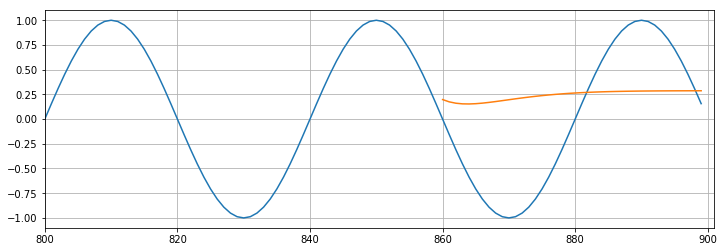

Epoch 3 Loss: 0.009651373140513897
Performance on test range: 0.3142699599266052


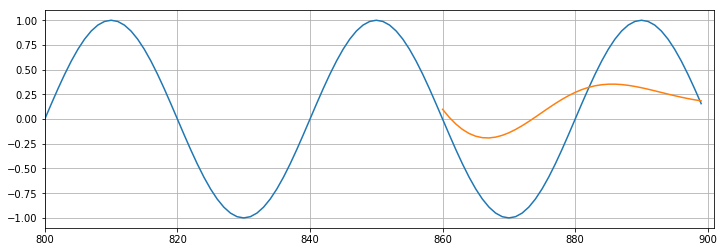

Epoch 4 Loss: 0.0011926604202017188
Performance on test range: 0.03478750213980675


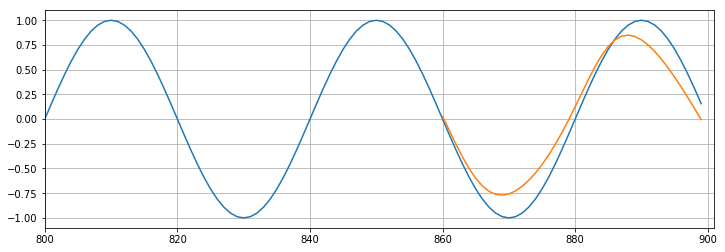

Epoch 5 Loss: 0.00035408762050792575
Performance on test range: 0.0027219203766435385


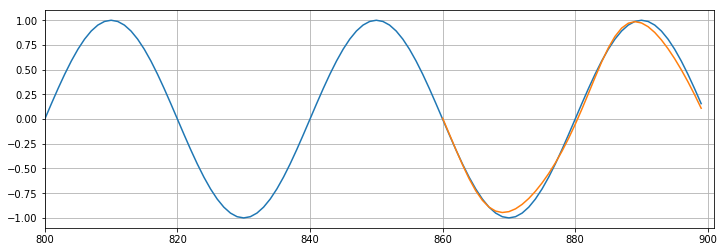

Epoch 6 Loss: 0.0002284706715727225
Performance on test range: 0.001849657972343266


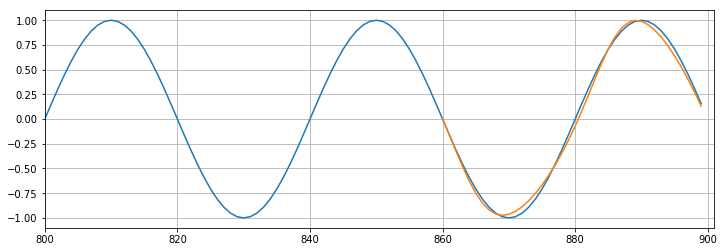

Epoch 7 Loss: 0.00017689677770249546
Performance on test range: 0.0017564734444022179


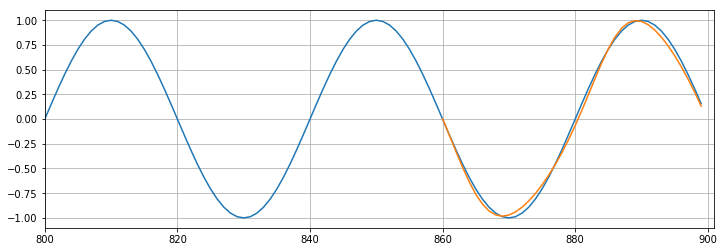

Epoch 8 Loss: 0.00014378715422935784
Performance on test range: 0.0017417912604287267


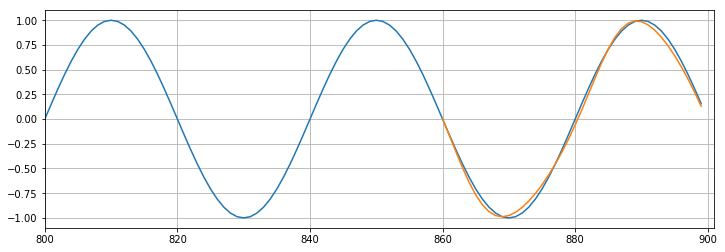

Epoch 9 Loss: 0.00012023164890706539
Performance on test range: 0.0017591060604900122


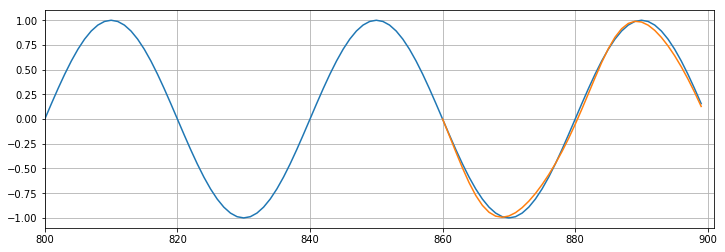

In [61]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq,y_train in train_data: # seq is the same as X_train from previous examples
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), 
                        torch.zeros(1,1,model.hidden_size)) # updating the hidden layer each epoch
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {i} Loss: {loss.item()}')

    pred = train_set[-window_size:].tolist()

    for f in range(future):
        seq = torch.FloatTensor(pred[-window_size:])
    
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size), 
                            torch.zeros(1,1,model.hidden_size))
        pred.append(model(seq).item()) # pushing the prediction to the end of the list so it will be part of the datasetin the next iteration
        
    loss = criterion(torch.tensor(pred[-window_size:]), y[-window_size:]) # comparing predictions vs test_set
    print(f'Performance on test range: {loss}')
    
    plt.figure(figsize=(12,4))
    plt.xlim(800,901)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(860,900), pred[window_size:])
    plt.show()

In [62]:
# predicting into the future
epochs = 15
window_size = 40
future = 40

all_data = input_data(y,window_size)
len(all_data)

860

In [63]:
import time
start = time.time()

for i in range(epochs):
    
    for seq,y_train in train_data: # seq is the same as X_train from previous examples
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {i} Loss: {loss.item()}')

    pred = train_set[-window_size:].tolist()

duration = time.time() - start
print(duration/60)

Epoch 0 Loss: 0.00010291908256476745
Epoch 1 Loss: 8.992549555841833e-05
Epoch 2 Loss: 7.998056389624253e-05
Epoch 3 Loss: 7.222888962132856e-05
Epoch 4 Loss: 6.606974784517661e-05
Epoch 5 Loss: 6.108895468059927e-05
Epoch 6 Loss: 5.698474342352711e-05
Epoch 7 Loss: 5.354163658921607e-05
Epoch 8 Loss: 5.06006290379446e-05
Epoch 9 Loss: 4.80469134345185e-05
Epoch 10 Loss: 4.5793160097673535e-05
Epoch 11 Loss: 4.3773379729827866e-05
Epoch 12 Loss: 4.194127905066125e-05
Epoch 13 Loss: 4.02586956624873e-05
Epoch 14 Loss: 3.869764259434305e-05
3.751983642578125


## Forecast into the future

In [66]:
pred = y[-window_size:].tolist()

for i in range(future):
    seq = torch.FloatTensor(pred[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
  
        pred.append(model(seq).item())

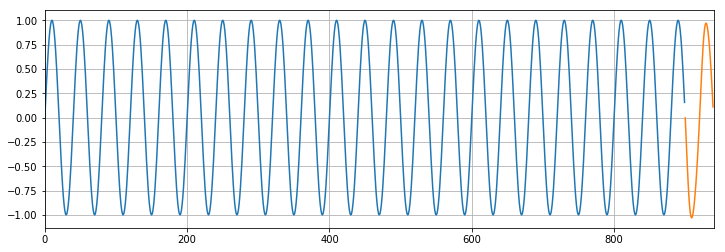

In [68]:
plt.figure(figsize=(12,4))
plt.xlim(0,941)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(900,940), pred[window_size:])
plt.show()